 # Google Stock Prediction

 ## About Dataset

 ### Context

All of the practitioners, learners in DL learning will surely come across RNN and LSTM's. So I thought let me add a dataset that can be used as a stepping stone into the Stock predictions.
Content
This dataset contains 14 columns and 1257 Rows. Each columns are assigned to a attribute and rows contains the values for that attribute.
The 14 columns are:

symbol : - Name of the company (in this case Google).
date :- year and date
close:- closing of stock value
high:- highest value of stock at that day
low:- lowest value of stock at that day
open:- opening value of stock at that day
volume
adjClose
adjHigh
adjLow
adjOpen
adjVolume
divCash
splitFactor
** Acknowledgements**
I would like to thank Tiingo for providing such a wonderful platform which maintains the financial and stock data and updates them day to day.
Predict the close and open values for the next 30 days. Can you guys do this?
Please up vote if you guys like this dataset.

https://www.kaggle.com/datasets/shreenidhihipparagi/google-stock-prediction/data                                                                                                                     

 ## 1. Data upload and first study

In [786]:
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.losses as losses
import tensorflow.keras.models as models
from tensorflow.keras import callbacks
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor

In [788]:
df = pd.read_csv('/Users/macbook/Desktop/Yandex Mashine Learning/Kaggle/Google_Stock_Prediction/GOOG.csv')

In [790]:
print(df.info())
print(df.head())
print(df.describe)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1258 non-null   object 
 1   date         1258 non-null   object 
 2   close        1258 non-null   float64
 3   high         1258 non-null   float64
 4   low          1258 non-null   float64
 5   open         1258 non-null   float64
 6   volume       1258 non-null   int64  
 7   adjClose     1258 non-null   float64
 8   adjHigh      1258 non-null   float64
 9   adjLow       1258 non-null   float64
 10  adjOpen      1258 non-null   float64
 11  adjVolume    1258 non-null   int64  
 12  divCash      1258 non-null   float64
 13  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 137.7+ KB
None
  symbol                       date   close    high       low    open  \
0   GOOG  2016-06-14 00:00:00+00:00  718.27  722.47  713.1200  716.48   
1   G

In [792]:
# Delete columns "symbol" and change column "date" to datetime
df = df.drop(['symbol'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   date         1258 non-null   datetime64[ns, UTC]
 1   close        1258 non-null   float64            
 2   high         1258 non-null   float64            
 3   low          1258 non-null   float64            
 4   open         1258 non-null   float64            
 5   volume       1258 non-null   int64              
 6   adjClose     1258 non-null   float64            
 7   adjHigh      1258 non-null   float64            
 8   adjLow       1258 non-null   float64            
 9   adjOpen      1258 non-null   float64            
 10  adjVolume    1258 non-null   int64              
 11  divCash      1258 non-null   float64            
 12  splitFactor  1258 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(10), int64(2)
memory usage: 127.9 KB


In [794]:
# Set column "date" to index and sort
df.set_index(['date']).sort_index(inplace=True)
df.index.is_monotonic_increasing

True

In [796]:
df = calculate_rsi(df)

 ## Analysis data

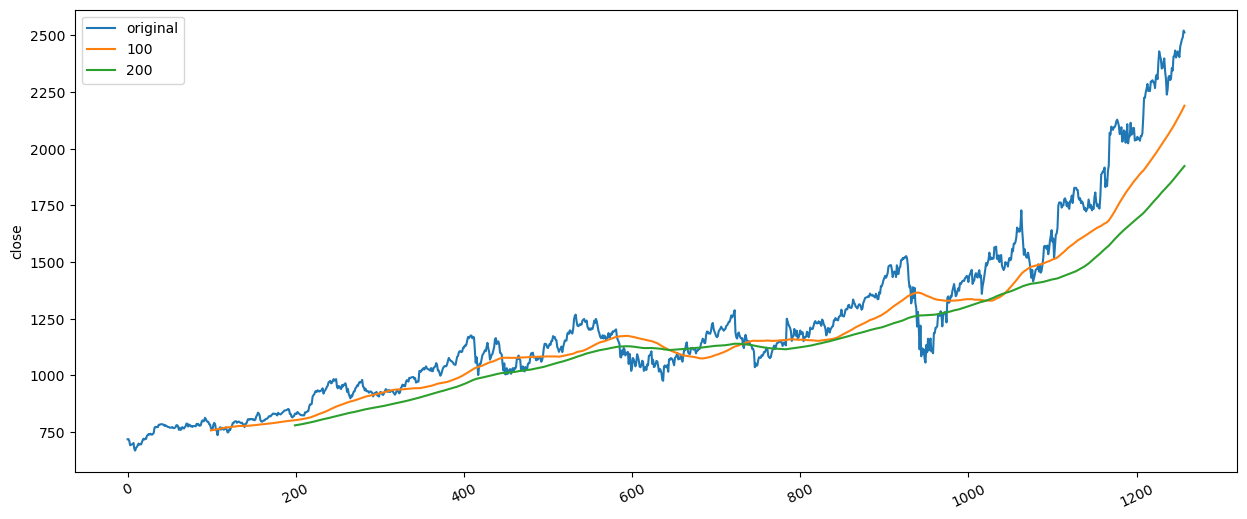

In [799]:
plt.figure(figsize=(15, 6))
sns.lineplot(df['close'], label='original')
sns.lineplot(df['close'].rolling(100).mean(), label='100')
sns.lineplot(df['close'].rolling(200).mean(), label='200')
plt.xticks(rotation = 25)
plt.show()

 ### Train test split

In [802]:
data = df['close'].values

In [804]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [806]:
train_size = int(len(data)*.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)
train_data = data_scaled[ :train_size , 0:1 ]
test_data = data_scaled[ train_size-60: , 0:1 ]

Train Size : 943 Test Size : 315


In [808]:
X_train = []
y_train = []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape , y_train.shape

((883, 60, 1), (883,))

In [810]:
X_test = []
y_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape , y_test.shape

((315, 60, 1), (315,))

In [812]:
def metrics(predictions, target):
    mae = mean_absolute_error(target, predictions)
    mse = mean_squared_error(target, predictions)
    rmse = np.sqrt(mse)
    r_squared = r2_score(target, predictions)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R_2': r_squared}

 ### Learn LTSM

In [815]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (X_train.shape[1], 1)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= ["mean_absolute_error"])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [817]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

In [819]:
checkpoints = callbacks.ModelCheckpoint("/Users/macbook/Desktop/Yandex Mashine Learning/Kaggle/Google_Stock_Prediction/weight/stock_pediction-{epoch:02d}-{mean_absolute_error:.2f}.keras",

                                        monitor='mean_absolute_error',

                                        mode='min',

                                        save_best_only=True)

In [821]:
history = model.fit(X_train, y_train, epochs= 100, callbacks= [checkpoints] )

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0124 - mean_absolute_error: 0.0842
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.3466e-04 - mean_absolute_error: 0.0238
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.5400e-04 - mean_absolute_error: 0.0150
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.3541e-04 - mean_absolute_error: 0.0148
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.2101e-04 - mean_absolute_error: 0.0144
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.2653e-04 - mean_absolute_error: 0.0136
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.7763e-04 - mean_absolute_error: 0.0134
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.1393e-04 - mean_absolute_error: 0.0129
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.9615e-04 - mean_absolute_error: 0.0127
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.5824e-04 - mean_absolute_error: 

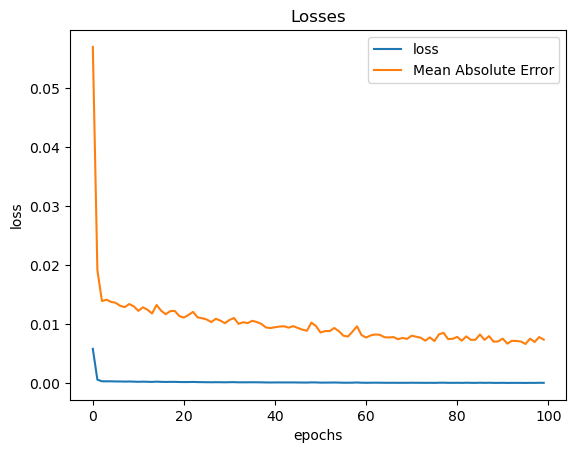

In [822]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['loss','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [823]:
min_val, min_index = np.inf,  0

for i in range(100):

  if min_val > history.history["mean_absolute_error"][i]:

    min_val = history.history["mean_absolute_error"][i]

    min_index = i

min_index, min_val

(95, 0.006683551240712404)

In [827]:
best_model = load_model('/Users/macbook/Desktop/Yandex Mashine Learning/Kaggle/Google_Stock_Prediction/weight/stock_pediction-96-0.01.keras')

In [829]:
# inverse y_test scaling
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [831]:
predictions = best_model.predict(X_test)
#inverse predictions scaling
predict = scaler.inverse_transform(predictions)
metrics(predict, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


{'MAE': 63.64863952442957,
 'MSE': 7646.94520255856,
 'RMSE': 87.44681356435213,
 'R_2': 0.9434931007696322}

 ## Simple model 

In [853]:
data = df['close'].values 

# Создаем новые признаки
features = []
for i in range(60, len(data)):
    features.append(data[i-60:i])

# Преобразуем в список
features = np.array(features)

# Разделяем данные на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(features, data[60:], test_size=0.25, random_state=40)

# Обучаем MinMaxScaler только на обучающих данных
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)

# Преобразуем тестовые данные с использованием scaler, обученного на тренировочных данных
X_test_scaled = scaler.transform(X_test)

# Изменяем форму массивов для LSTM (если вы используете LSTM)
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Теперь X_train_scaled и X_test_scaled готовы к использованию
features_train, target_train = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1])), y_train
features_test, target_test = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1])), y_test

In [857]:
features_train, target_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1])), y_train
features_test, target_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1])), y_test

 ### Train Linear Regression model¶

In [860]:
fit_intercepts = [True, False]
best_result = -100
linear_regres, best_fit_intercept = None, None

for fit_intercept in fit_intercepts:
    model = LinearRegression(fit_intercept=fit_intercept)
    
    scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
    result = np.mean(scores)  
    

    if result > best_result:
        linear_regres = model
        best_result = result
        best_fit_intercept = fit_intercept



# Train model
linear_regres.fit(features_train, target_train)

# Received predictions
predictions = linear_regres.predict(features_test)

lin_reg = metrics(predictions, target_test)


print(f'The best parameters: fit_intercept={best_fit_intercept}')
print(f'Metrics: {lin_reg}')

The best parameters: fit_intercept=True
Metrics: {'MAE': 14.741557324968083, 'MSE': 461.487281990778, 'RMSE': 21.482255049011453, 'R_2': 0.9962622354066096}


 ### Train DecisionTree Model¶

In [863]:
min_samples_splits = [2, 5, 10]
best_result = -100
best_params = None
decision_tree_regressor = None

for max_depth in range(1, 16):
    for min_samples_split in min_samples_splits:
        model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split)
        
        scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
        result = np.mean(scores)  

        if result > best_result:
            decision_tree_regressor = model
            best_result = result
            best_params = (max_depth, min_samples_split)

# Train model
decision_tree_regressor.fit(features_train, target_train)

# Receive predictions
predictions = decision_tree_regressor.predict(features_test)


dec_reg = metrics(predictions, target_test)

print(f'The best parameters: max_depth={best_params[0]}, min_samples_split={best_params[1]}')
print(f'Metrics: {dec_reg}')

The best parameters: max_depth=7, min_samples_split=10
Metrics: {'MAE': 24.75800611340362, 'MSE': 2835.4865574394275, 'RMSE': 53.24928691953938, 'R_2': 0.9770342939599289}


 ### Train CatBoostRegressor model¶

In [865]:
catboost_params = {
    'iterations': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [3, 5, 7]
}

best_result_catboost = -100
best_params_catboost = None
catboost_regressor = None

for iterations in catboost_params['iterations']:
    for learning_rate in catboost_params['learning_rate']:
        for depth in catboost_params['depth']:
            model = CatBoostRegressor(iterations=iterations, learning_rate=learning_rate, depth=depth, verbose=0)
            
            scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
            result = np.mean(scores)

            if result > best_result_catboost:
                catboost_regressor = model
                best_result_catboost = result
                best_params_catboost = (iterations, learning_rate, depth)

# Обучение модели
catboost_regressor.fit(features_train, target_train)

# Получение предсказаний
predictions_catboost = catboost_regressor.predict(features_test)

# Вычисление метрик
catboost_metrics = metrics(predictions_catboost, target_test)

print(f'CatBoost - The best parameters: iterations={best_params_catboost[0]}, learning_rate={best_params_catboost[1]}, depth={best_params_catboost[2]}')
print(f'CatBoost - Metrics: {catboost_metrics}')

CatBoost - The best parameters: iterations=150, learning_rate=0.1, depth=7
CatBoost - Metrics: {'MAE': 20.672240150108863, 'MSE': 798.0184427199238, 'RMSE': 28.24922021436917, 'R_2': 0.9935365389329825}


 ### Train LGBMRegressor model

In [867]:
lgbm_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, -1]  # -1 означает отсутствие ограничения
}

best_result_lgbm = 0
best_params_lgbm = None
lgbm_regressor = None

for n_estimators in lgbm_params['n_estimators']:
    for learning_rate in lgbm_params['learning_rate']:
        for max_depth in lgbm_params['max_depth']:
            model = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, verbose=0)
            
            scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
            result = np.mean(scores)

            if result > best_result_lgbm:
                lgbm_regressor = model
                best_result_lgbm = result
                best_params_lgbm = (n_estimators, learning_rate, max_depth)

# Обучение модели
lgbm_regressor.fit(features_train, target_train)

# Получение предсказаний
predictions_lgbm = lgbm_regressor.predict(features_test)

# Вычисление метрик
lgbm_metrics = metrics(predictions_lgbm, target_test)

print(f'LGBM - The best parameters: n_estimators={best_params_lgbm[0]}, learning_rate={best_params_lgbm[1]}, max_depth={best_params_lgbm[2]}')
print(f'LGBM - Metrics: {lgbm_metrics}')

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 ### Train MLPRegressor model

In [869]:
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 300]
}

best_result_mlp = 0
best_params_mlp = None
mlp_regressor = None

for hidden_layer_sizes in mlp_params['hidden_layer_sizes']:
    for activation in mlp_params['activation']:
        for learning_rate_init in mlp_params['learning_rate_init']:
            for max_iter in mlp_params['max_iter']:
                model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                                     activation=activation,
                                     learning_rate_init=learning_rate_init,
                                     max_iter=max_iter,
                                     random_state=42,
                                     verbose=0)
                
                scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
                result = np.mean(scores)

                if result > best_result_mlp:
                    mlp_regressor = model
                    best_result_mlp = result
                    best_params_mlp = (hidden_layer_sizes, activation, learning_rate_init, max_iter)

# Обучение модели
mlp_regressor.fit(features_train, target_train)

# Получение предсказаний
predictions_mlp = mlp_regressor.predict(features_test)

# Вычисление метрик
mlp_metrics = metrics(predictions_mlp, target_test)

print(f'MLP - The best parameters: hidden_layer_sizes={best_params_mlp[0]}, activation={best_params_mlp[1]}, learning_rate_init={best_params_mlp[2]}, max_iter={best_params_mlp[3]}')
print(f'MLP - Metrics: {mlp_metrics}')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_

MLP - The best parameters: hidden_layer_sizes=(50, 50), activation=relu, learning_rate_init=0.001, max_iter=300
MLP - Metrics: {'MAE': 26.452084422092977, 'MSE': 1235.62725982149, 'RMSE': 35.151490150795745, 'R_2': 0.9899921752936172}


 ### Train BaggingRegressor model¶

In [871]:
bagging_params = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

best_result_bagging = 0
best_params_bagging = None
bagging_regressor = None

for n_estimators in bagging_params['n_estimators']:
    for max_samples in bagging_params['max_samples']:
        for max_features in bagging_params['max_features']:
            model = BaggingRegressor(n_estimators=n_estimators, 
                                      max_samples=max_samples, 
                                      max_features=max_features,
                                      random_state=42)  # Установите random_state для воспроизводимости
            
            scores = cross_val_score(model, features_train, target_train, cv=5, scoring='r2')
            result = np.mean(scores)

            if result > best_result_bagging:
                bagging_regressor = model
                best_result_bagging = result
                best_params_bagging = (n_estimators, max_samples, max_features)


bagging_regressor.fit(features_train, target_train)


predictions_bagging = bagging_regressor.predict(features_test)


bagging_metrics = metrics(predictions_bagging, target_test)

print(f'Bagging - The best parameters: n_estimators={best_params_bagging[0]}, max_samples={best_params_bagging[1]}, max_features={best_params_bagging[2]}')
print(f'Bagging - Metrics: {bagging_metrics}')

Bagging - The best parameters: n_estimators=100, max_samples=1.0, max_features=0.8
Bagging - Metrics: {'MAE': 16.230281333333338, 'MSE': 568.6172675278677, 'RMSE': 23.845697044285952, 'R_2': 0.995394548078145}


 ### Conclusion: the best model is Logisticregression with metrics RMSE - 21.4 and R2 - 99.6%